<a href="https://colab.research.google.com/github/xquynhtrinh/STA_141C_Final_Project/blob/main/Predictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Modeling Goals
- Recalc Logs
- K-Means clustering
- Find optimal K through Elbow method
- Fit final k-means
- Do a train/test split
- Train logistic regression & Random Forest


In [39]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score
from sklearn.model_selection import train_test_split

## Load Data & Recalc. Logs

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/STA 141C/manual_segments_data.csv")

In [6]:
# Set customer id to index to keep it out of ML features
if 'Customer ID' in df.columns:
    df = df.set_index('Customer ID')

# Recreate log-transf.
if 'Log_R' not in df.columns:
    df['Log_R'] = np.log1p(df['Recency'])
    df['Log_F'] = np.log1p(df['Frequency'])
    df['Log_M'] = np.log1p(df['Monetary'])


## K-Means Clustering

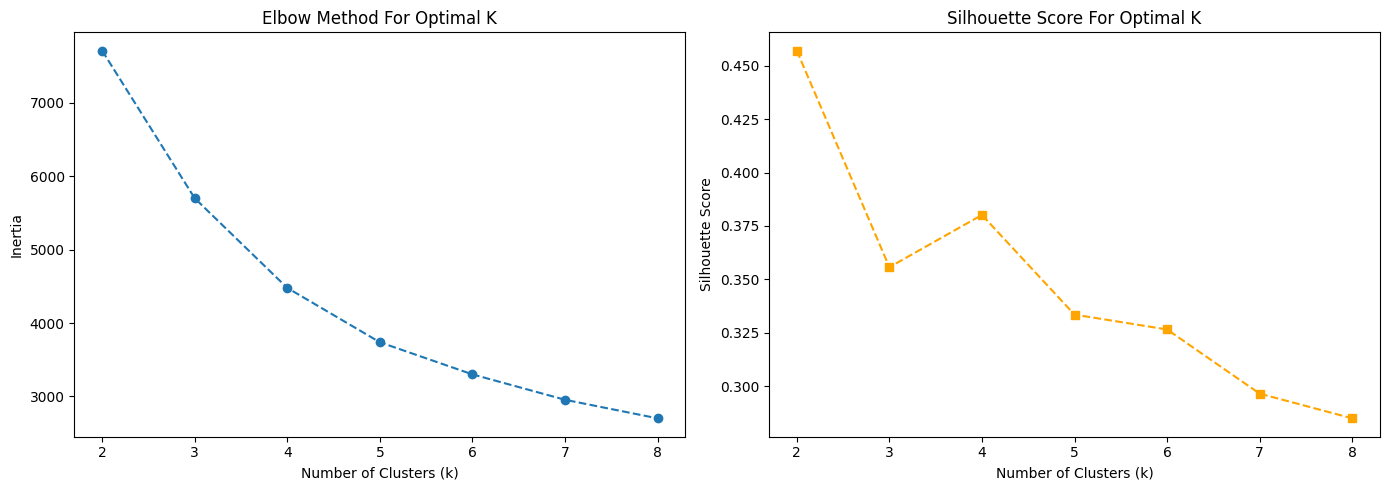

In [17]:
# Select log-transf variables for kmeans
df_kmeans = df[['Log_R', 'Log_F', 'Log_M']].copy()

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans)

# Find optimal k using elbow method & silhouette score
inertia = []
silhouette_scores = [] # Renamed to avoid conflict with the function
K_range = range(2,9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(sil_score(X_scaled, kmeans.labels_)) # Using the alias for the function

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot
axes[0].plot(K_range, inertia, marker='o', linestyle='--')
axes[0].set_title('Elbow Method For Optimal K')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')

# Silhouette Score Plot
axes[1].plot(K_range, silhouette_scores, marker='s', color='orange', linestyle='--') # Plotting the list
axes[1].set_title('Silhouette Score For Optimal K')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [19]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Add kmeans clsuter back to df
df['K_Means_Cluster'] = kmeans_final.fit_predict(X_scaled)

## Encoding
Convert manual RFM Customer Segment into binary column

In [26]:
# Initialize df_model from df
df_model = df.copy()

if 'RFM_Customer_Segments' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['RFM_Customer_Segments'], drop_first=True)

# Also convert K-Means cluster to category and encode it
if 'K_Means_Cluster' in df_model.columns:
    df_model['K_Means_Cluster'] = df_model['K_Means_Cluster'].astype(str)
    df_model = pd.get_dummies(df_model, columns=['K_Means_Cluster'], drop_first=True)

## Train/Test Split

In [27]:
target_col = 'Next_90_Days_Purchase' # Corrected typo (Day -> Days)

if target_col in df_model.columns:
  X = df_model.drop(columns=[target_col])
  y = df_model[target_col]

  # 80 training, 20 test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print("Train/Test split created successfully.")
else:
  print(f"Error: Target column '{target_col}' not found in dataframe.")

Train/Test split created successfully.


## Baseline Model: Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [40]:
# Ensure all features are on the same scale
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Init. & train model
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

#Evaluate
print(classification_report(y_test, y_pred_lr))
print(roc_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       600
           1       0.68      0.70      0.69       456

    accuracy                           0.73      1056
   macro avg       0.72      0.72      0.72      1056
weighted avg       0.73      0.73      0.73      1056

0.8013633040935673


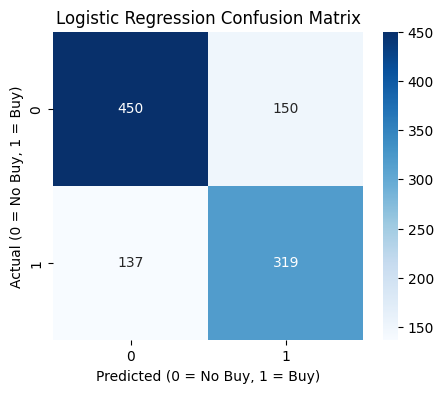

In [41]:
# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted (0 = No Buy, 1 = Buy)')
plt.ylabel('Actual (0 = No Buy, 1 = Buy)')
plt.show()

## Random Forest (Flexible Model)

- We don't need scaled data, so we use the original X_train

- class_weight = 'balanced" helps to deal with the fact fewer people return than churn

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       600
           1       0.70      0.70      0.70       456

    accuracy                           0.74      1056
   macro avg       0.73      0.74      0.73      1056
weighted avg       0.74      0.74      0.74      1056



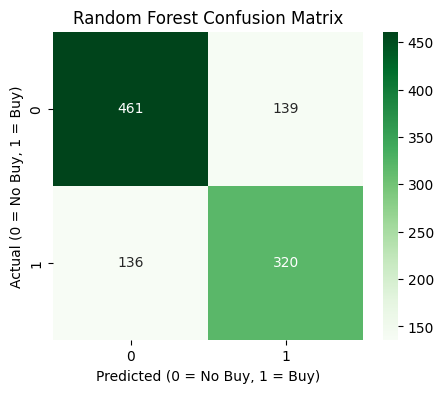

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=7)
rf_model.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted (0 = No Buy, 1 = Buy)')
plt.ylabel('Actual (0 = No Buy, 1 = Buy)')
plt.show()


## XGBoost

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       600
           1       0.67      0.71      0.69       456

    accuracy                           0.72      1056
   macro avg       0.72      0.72      0.72      1056
weighted avg       0.72      0.72      0.72      1056



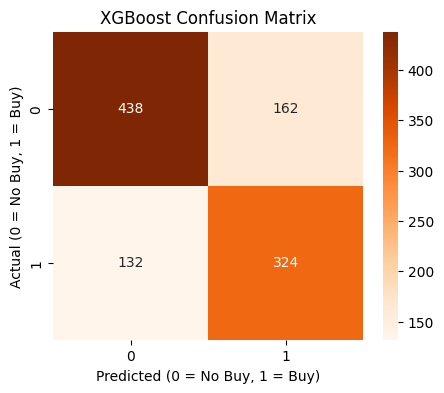

In [61]:
from xgboost import XGBClassifier

# Calc ratio of neg to pos classes to handle class imbalance
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# init xgboost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    scale_pos_weight=imbalance_ratio,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Make prediction
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted (0 = No Buy, 1 = Buy)')
plt.ylabel('Actual (0 = No Buy, 1 = Buy)')
plt.show()

## ROC Curve Comparison

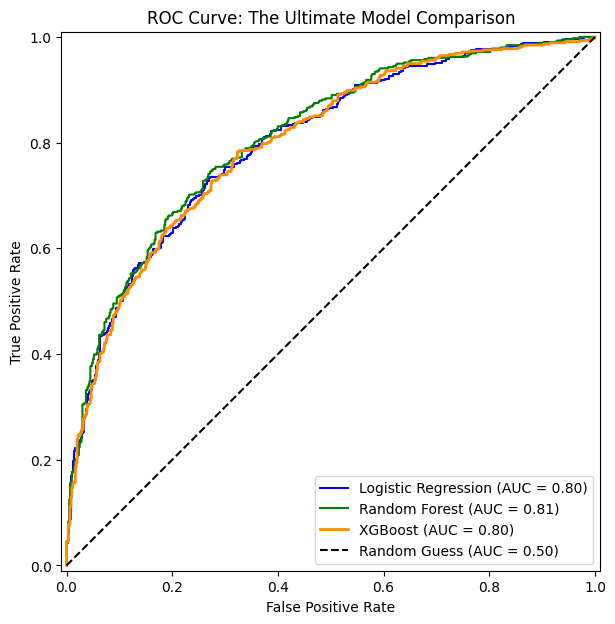

In [55]:
plt.figure(figsize=(9, 7))

# Plot all three
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression", ax=plt.gca(), color='blue')
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest", ax=plt.gca(), color='green')
RocCurveDisplay.from_predictions(y_test, y_prob_xgb, name="XGBoost", ax=plt.gca(), color='darkorange', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.title('ROC Curve: The Ultimate Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importances

- Answer the question "What makes a customer come back"

In [62]:
# importances = rf_model.feature_importances_
# feature_names = X_train.columns

# # create df and sort importances
# feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
# plt.title('Top 10 Most Important Features for Predicting Next 90-Day Purchase')
# plt.xlabel('Relative Importance (Random Forest)')
# plt.ylabel('Feature')
# plt.show()